#### **DATA 622 - Assignment 2 - Decision Trees Algorithms**

Author: Kory Martin     
Date: 3/18/2024


**Instructions:**

Pre-work:
- Read this blog: https://decizone.com/blog/the-good-the-bad-the-ugly-of-using-decision-trees which shows some of the issues with decision trees
- Choose a dataset from a source in Assignment #1, or another dataset of your choice.

Assignment work:
- Based on the latest topics presented, choose a dataset of your choice and create a Decision Tree where you can solve a classification problem and predict the outcome of a particular feature or detail of the data used.
- Switch variables* to generate 2 decision trees and compare the results. Create a random forest and analyze the results.
- Based on real cases where desicion trees went wrong, and 'the bad & ugly' aspects of decision trees (https://decizone.com/blog/the-good-the-bad-the-ugly-of-using-decision-trees), how can you change this perception when using the decision tree you created to solve a real problem?

Deliverable:
- Essay (minimum 500 word document)
- Write a short essay explaining your analysis, and how you would address the concerns in the blog (listed in pre-work)
- Exploratory Analysis using R or Python (submit code + errors + analysis as notebook or copy/paste to document)


Note:
1. We are trying to train 2 different decision trees to compare bias and variance - so swicth the features used for the first node (split) to force a different decision tree (How did the performance change?)
2. You will create 3 models: 2 x decision trees (to compare variance) and a random forest

#### **1. Import Libraries**

In [2]:
import pandas as pd
from plotnine import *
from datetime import datetime as dt
import re

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#### **2. Import Data**

For this assignment, I pulled the [eCommerce Customer Service Satisfaction](https://www.kaggle.com/datasets/ddosad/ecommerce-customer-service-satisfaction) data from Kaggle. This dataset provides a list of customer satisfaction scores and information for various customer inquiries. The output variable that we will use for this assignment is the final CSAT score that the user gave the support agent. 

Given the richness of the dataset, our goal will be to build a model that can predict the CSAT score based on the input features.

In [118]:
cust_satisfaction_df = pd.read_csv('Customer_support_data.csv')

#### **3. Exploratory Analysis**

In [6]:
cust_satisfaction_df.shape

(85907, 20)

We see that the dataset has 85K rows and 20 different fields, which are a mix of data types including dates, strings and categorical variables. When we look at the first few rows of the data, we also notice that there are NA values in the data, and also there are some variables that are specific to the data in the row, but that we would assume may not have much generalizable characteristics that would make it worth keeping in our final data table

In [7]:
cust_satisfaction_df.head()

,Unique id,channel_name,category,Sub-category,Customer Remarks,Order_id,order_date_time,Issue_reported at,issue_responded,Survey_response_Date,Customer_City,Product_category,Item_price,connected_handling_time,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score
0,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,Outcall,Product Queries,Life Insurance,NaN,c27c9bb4-fa36-4140-9f1f-21009254ffdb,NaN,01/08/2023 11:13,01/08/2023 11:47,01-Aug-23,NaN,NaN,NaN,NaN,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5
1,b07ec1b0-f376-43b6-86df-ec03da3b2e16,Outcall,Product Queries,Product Specific Information,NaN,d406b0c7-ce17-4654-b9de-f08d421254bd,NaN,01/08/2023 12:52,01/08/2023 12:54,01-Aug-23,NaN,NaN,NaN,NaN,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5
2,200814dd-27c7-4149-ba2b-bd3af3092880,Inbound,Order Related,Installation/demo,NaN,c273368d-b961-44cb-beaf-62d6fd6c00d5,NaN,01/08/2023 20:16,01/08/2023 20:38,01-Aug-23,NaN,NaN,NaN,NaN,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5
3,eb0d3e53-c1ca-42d3-8486-e42c8d622135,Inbound,Returns,Reverse Pickup Enquiry,NaN,5aed0059-55a4-4ec6-bb54-97942092020a,NaN,01/08/2023 20:56,01/08/2023 21:16,01-Aug-23,NaN,NaN,NaN,NaN,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5
4,ba903143-1e54-406c-b969-46c52f92e5df,Inbound,Cancellation,Not Needed,NaN,e8bed5a9-6933-4aff-9dc6-ccefd7dcde59,NaN,01/08/2023 10:30,01/08/2023 10:32,01-Aug-23,NaN,NaN,NaN,NaN,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5


As we noticed during the previous of the table, there are at least seven fields that have NA values; with a number of these having a significant majority or near-majority of their values that are NA. ***connected_handling_time*** has only 242 non-null values.

In [44]:
cust_satisfaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85907 entries, 0 to 85906
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unique id                85907 non-null  object        
 1   channel_name             85907 non-null  object        
 2   category                 85907 non-null  object        
 3   Sub-category             85907 non-null  object        
 4   Customer Remarks         28742 non-null  object        
 5   Order_id                 67675 non-null  object        
 6   order_date_time          17214 non-null  object        
 7   Issue_reported at        85907 non-null  object        
 8   issue_responded          85907 non-null  object        
 9   Survey_response_Date     85907 non-null  object        
 10  Customer_City            17079 non-null  object        
 11  Product_category         17196 non-null  object        
 12  Item_price               17206 n

I noticed that the date strings were not in a standard US date format, so went ahead and updated the strings. The thinking is that it may be valuable to create a feature that represents the amount of time between an issue being reported and when it was resolved.

In [119]:
cust_satisfaction_df['order_date'] = cust_satisfaction_df['order_date_time'].apply(lambda x: dt.strptime(str(x)[:10],'%d/%m/%Y') if not pd.isna(x) else x).copy()
cust_satisfaction_df['response_date'] = cust_satisfaction_df['issue_responded'].apply(lambda x: dt.strptime(str(x)[:10],'%d/%m/%Y') if not pd.isna(x) else x).copy()
cust_satisfaction_df['issue_date'] = cust_satisfaction_df['Issue_reported at'].apply(lambda x: dt.strptime(str(x)[:10],'%d/%m/%Y') if not pd.isna(x) else x).copy()

I have a preference for consisting naming conventions for feature names, so I'm going to update the column names to a consistent format

In [120]:
col_names = [col.lower() for col in cust_satisfaction_df.columns]
col_names = [re.sub('[-\s]',"_",col) for col in col_names]
cust_satisfaction_df = cust_satisfaction_df.set_axis(col_names, axis='columns')

In [121]:
cust_satisfaction_df.head()

,unique_id,channel_name,category,sub_category,customer_remarks,order_id,order_date_time,issue_reported_at,issue_responded,survey_response_date,...,connected_handling_time,agent_name,supervisor,manager,tenure_bucket,agent_shift,csat_score,order_date,response_date,issue_date
0,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,Outcall,Product Queries,Life Insurance,NaN,c27c9bb4-fa36-4140-9f1f-21009254ffdb,NaN,01/08/2023 11:13,01/08/2023 11:47,01-Aug-23,...,NaN,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5,NaT,2023-08-01,2023-08-01
1,b07ec1b0-f376-43b6-86df-ec03da3b2e16,Outcall,Product Queries,Product Specific Information,NaN,d406b0c7-ce17-4654-b9de-f08d421254bd,NaN,01/08/2023 12:52,01/08/2023 12:54,01-Aug-23,...,NaN,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5,NaT,2023-08-01,2023-08-01
2,200814dd-27c7-4149-ba2b-bd3af3092880,Inbound,Order Related,Installation/demo,NaN,c273368d-b961-44cb-beaf-62d6fd6c00d5,NaN,01/08/2023 20:16,01/08/2023 20:38,01-Aug-23,...,NaN,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5,NaT,2023-08-01,2023-08-01
3,eb0d3e53-c1ca-42d3-8486-e42c8d622135,Inbound,Returns,Reverse Pickup Enquiry,NaN,5aed0059-55a4-4ec6-bb54-97942092020a,NaN,01/08/2023 20:56,01/08/2023 21:16,01-Aug-23,...,NaN,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5,NaT,2023-08-01,2023-08-01
4,ba903143-1e54-406c-b969-46c52f92e5df,Inbound,Cancellation,Not Needed,NaN,e8bed5a9-6933-4aff-9dc6-ccefd7dcde59,NaN,01/08/2023 10:30,01/08/2023 10:32,01-Aug-23,...,NaN,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5,NaT,2023-08-01,2023-08-01


Now that we've done some initial pre-processing and cleaning of the data, we can begin to explore the data and look for interesting insights that may be able to inform how we build our models. 

Some interesting questions that we can answer based on this data are:
- Are there any significant differences in CSAT score based on the categorical variables?
- Are there significant differences in the CSAT score based on the agents supervisors and managers associated with the response? 

##### *3.1 Average CSAT Score based on Channel*

In [10]:
cust_satisfaction_df.pivot_table(index=['channel_name'], values=['csat_score'])

,csat_score
channel_name,
Email,3.899107
Inbound,4.251372
Outcall,4.269909


##### *3.2 Average CSAT Score based on Customer Issue*

In [11]:
cust_satisfaction_df.pivot_table(index=['category'], values=['csat_score'])

,csat_score
category,
App/website,4.404762
Cancellation,3.990506
Feedback,4.158675
Offers & Cashback,4.210417
Onboarding related,4.261538
Order Related,4.096059
Others,3.434343
Payments related,4.354534
Product Queries,4.039816


In [12]:
temp_df = cust_satisfaction_df.pivot_table(index=['category'], values=['csat_score']).reset_index()

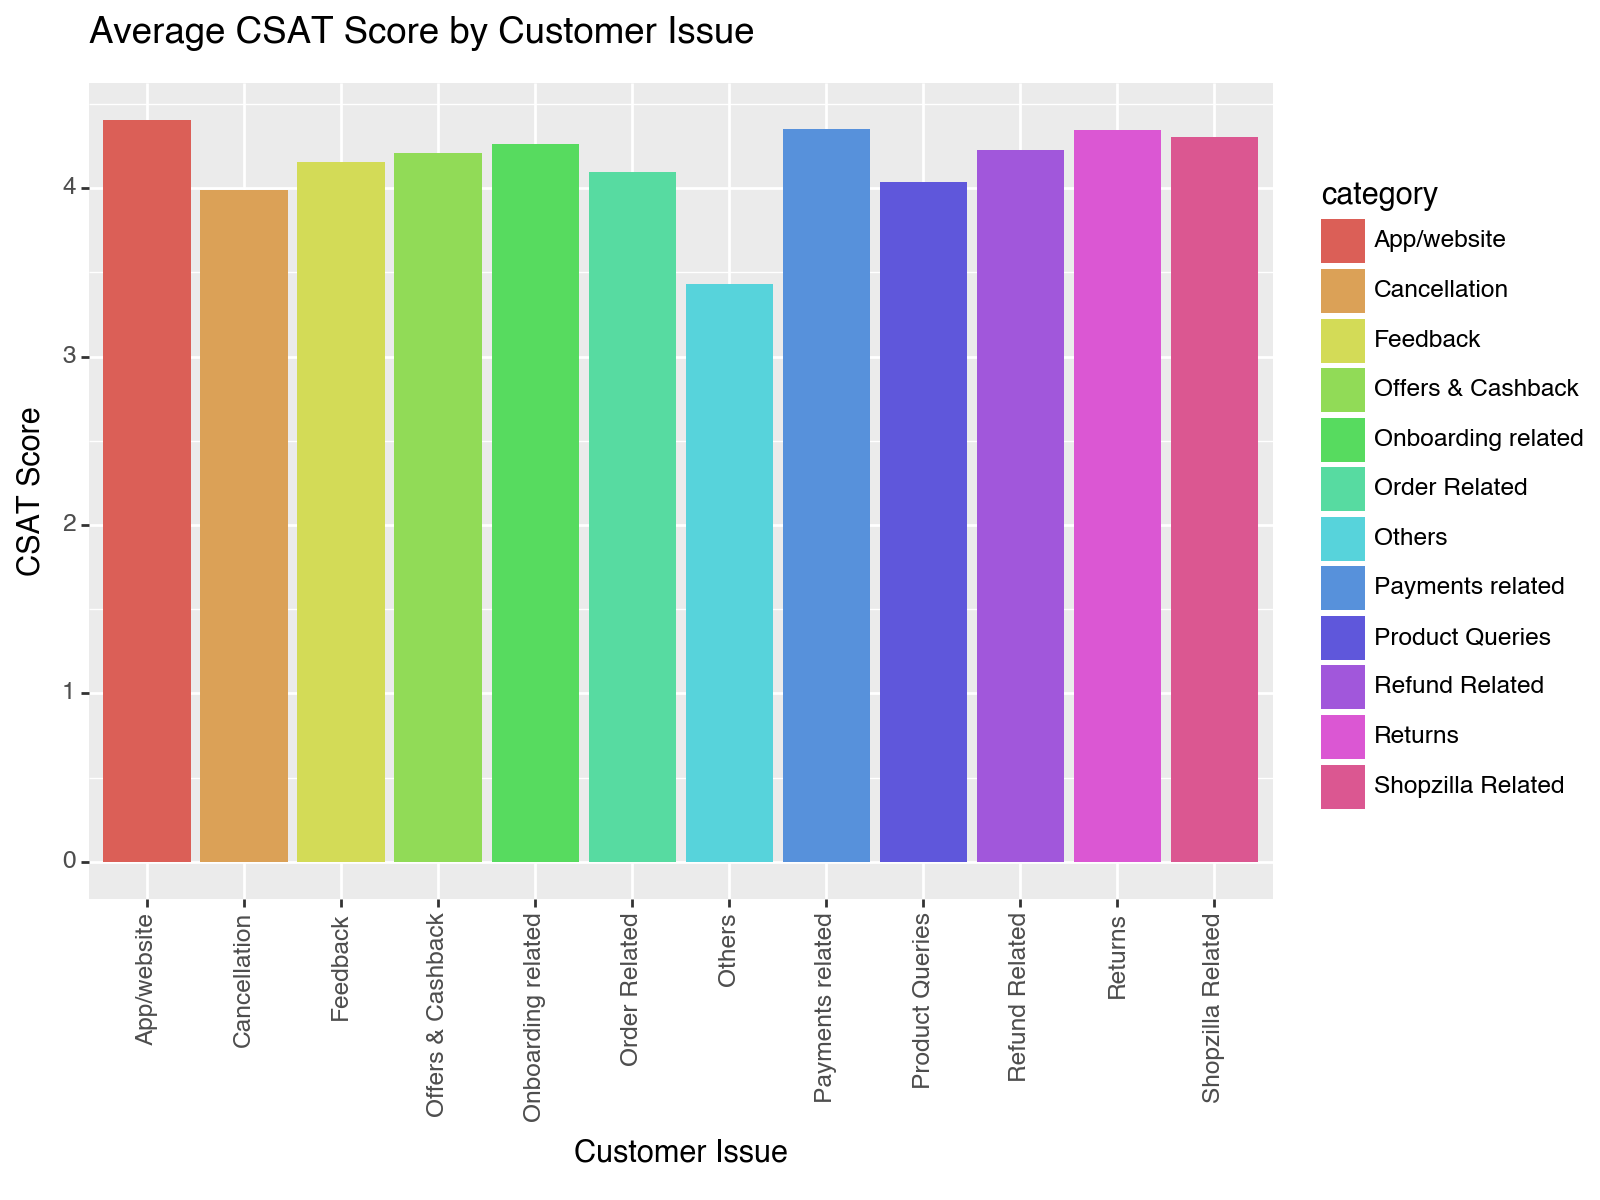

<Figure Size: (800 x 600)>

In [32]:
(
    ggplot(temp_df)
    + aes(x='category', y='csat_score', fill='category')
    + geom_bar(stat='identity')
    + theme(axis_text_x=(element_text(rotation=90)), figure_size=(8,6))
    + labs(title="Average CSAT Score by Customer Issue", y='CSAT Score', x='Customer Issue')

)


##### *3.3 Average CSAT Score based on Supervisor*

For this we look to see if there are any significant differences in the CSAT score based on the supervisor of the associated agent

In [36]:
temp_df = cust_satisfaction_df.pivot_table(index=['supervisor'], values=['csat_score']).reset_index()

In [41]:
temp_df.sort_values(by='csat_score', ascending=False).head(10)['csat_score'].mean()

4.365244769944317

In [42]:
temp_df.sort_values(by='csat_score', ascending=False).tail(10)['csat_score'].mean()

4.02003806008935

Looking at the average CSAT scores for customer inquiries for agents supervised by supervisors in the top10 of customer satisfaction scores vs. the bottom 10, we see that there's a difference in nearly 35 bps between the the two tiers or groups of agents. This suggests that there may be some differences either in the quality of leadership or possibly there may be other differences between the agents on certain teams that is evident when we evaluate the performance based on the agents supervisor

##### *3.4 Average CSAT Score based on Manager*


In [43]:
cust_satisfaction_df.pivot_table(index=['manager'], values=['csat_score']).reset_index()

,manager,csat_score
0,Emily Chen,4.379107
1,Jennifer Nguyen,4.158583
2,John Smith,4.270694
3,Michael Lee,4.259602
4,Olivia Tan,4.112193
5,William Kim,4.121032


##### *3.5 Average CSAT Score based on Tenure Bucket*


In [46]:
cust_satisfaction_df.pivot_table(index=['tenure_bucket'], values=['csat_score']).reset_index()

,tenure_bucket,csat_score
0,0-30,4.258791
1,31-60,4.296185
2,61-90,4.346536
3,>90,4.273190
4,On Job Training,4.145242


When we sort the csat score based on agent tenure, we see that CSAT Scores are lower amongst longer tenured agents vs. those who have been there between 31 and 90 days. I suspect that this is most likely due to the fact that the scores are maybe brought down by agents who have much longer tenures than 90-days, and who may be more apathetic. Additionally, it's likely that agents are on their best behavior during their 90-day probationary period, and then become a bit more relaxed once they past this threshold

In [49]:
cust_satisfaction_df.pivot_table(index=['tenure_bucket'], values=['csat_score']).\
    reset_index().sort_values(by='csat_score', ascending=False)

,tenure_bucket,csat_score
2,61-90,4.346536
1,31-60,4.296185
3,>90,4.273190
0,0-30,4.258791
4,On Job Training,4.145242


##### *3.6 Average CSAT Score based on Agent Shift*


In [45]:
cust_satisfaction_df.pivot_table(index=['agent_shift'], values=['csat_score']).reset_index()

,agent_shift,csat_score
0,Afternoon,4.292295
1,Evening,4.276361
2,Morning,4.189495
3,Night,4.288754
4,Split,4.427357


It makes sense that the scores would be a bit lower in the morning compared to other shifts. This is probably a function of the agents being tired and the customers themselves are probably a bit more agitated and frustrated if they are having to spend their mornings dealing with customer service matters. 

In [48]:
cust_satisfaction_df.pivot_table(index=['agent_shift'], values=['csat_score']).\
    reset_index().sort_values(by='csat_score', ascending=False)

,agent_shift,csat_score
4,Split,4.427357
0,Afternoon,4.292295
3,Night,4.288754
1,Evening,4.276361
2,Morning,4.189495


In addition to evaluating differences in the CSAT score based on different quualitative factors, I think it's also worth evaluating if there are certain responses that are more prevelant than others and if there are certain shifts that receive more calls then others. This information could be helpful to the organization to evaluate staffing needs as well as to identify if there are any particular product issues or categories that generate more complaints

##### *3.6 Number of Issues by Category*

In [54]:
temp_df = pd.DataFrame(cust_satisfaction_df['category'].value_counts()).reset_index()

In [57]:
total_issues = temp_df['count'].sum()

In [59]:
temp_df['pct_total'] = temp_df.apply(lambda x: x['count']/total_issues, axis=1)

In [62]:
temp_df['cum_pct'] = temp_df['pct_total'].cumsum()

In [92]:
temp_df.sort_values(by='pct_total')

,category,count,pct_total,cum_pct,sorted_cats
11,Onboarding related,65,0.000757,1.000000,Onboarding related
10,App/website,84,0.000978,0.999243,App/website
9,Others,99,0.001152,0.998266,Others
8,Offers & Cashback,480,0.005587,0.997113,Offers & Cashback
7,Cancellation,2212,0.025749,0.991526,Cancellation
6,Feedback,2294,0.026703,0.965777,Feedback
5,Payments related,2327,0.027087,0.939074,Payments related
4,Shopzilla Related,2792,0.032500,0.911986,Shopzilla Related
3,Product Queries,3692,0.042977,0.879486,Product Queries
2,Refund Related,4550,0.052964,0.836509,Refund Related


In [86]:
temp_df.category

0                Returns
1          Order Related
2         Refund Related
3        Product Queries
4      Shopzilla Related
5       Payments related
6               Feedback
7           Cancellation
8      Offers & Cashback
9                 Others
10           App/website
11    Onboarding related
Name: category, dtype: object

In [110]:
temp_df['sorted_cats'] = pd.Categorical(temp_df.category, pd.unique(temp_df.sort_values(by='pct_total').category),ordered=True)

In [111]:
temp_df

,category,count,pct_total,cum_pct,sorted_cats
0,Returns,44097,0.513311,0.513311,Returns
1,Order Related,23215,0.270234,0.783545,Order Related
2,Refund Related,4550,0.052964,0.836509,Refund Related
3,Product Queries,3692,0.042977,0.879486,Product Queries
4,Shopzilla Related,2792,0.032500,0.911986,Shopzilla Related
5,Payments related,2327,0.027087,0.939074,Payments related
6,Feedback,2294,0.026703,0.965777,Feedback
7,Cancellation,2212,0.025749,0.991526,Cancellation
8,Offers & Cashback,480,0.005587,0.997113,Offers & Cashback
9,Others,99,0.001152,0.998266,Others


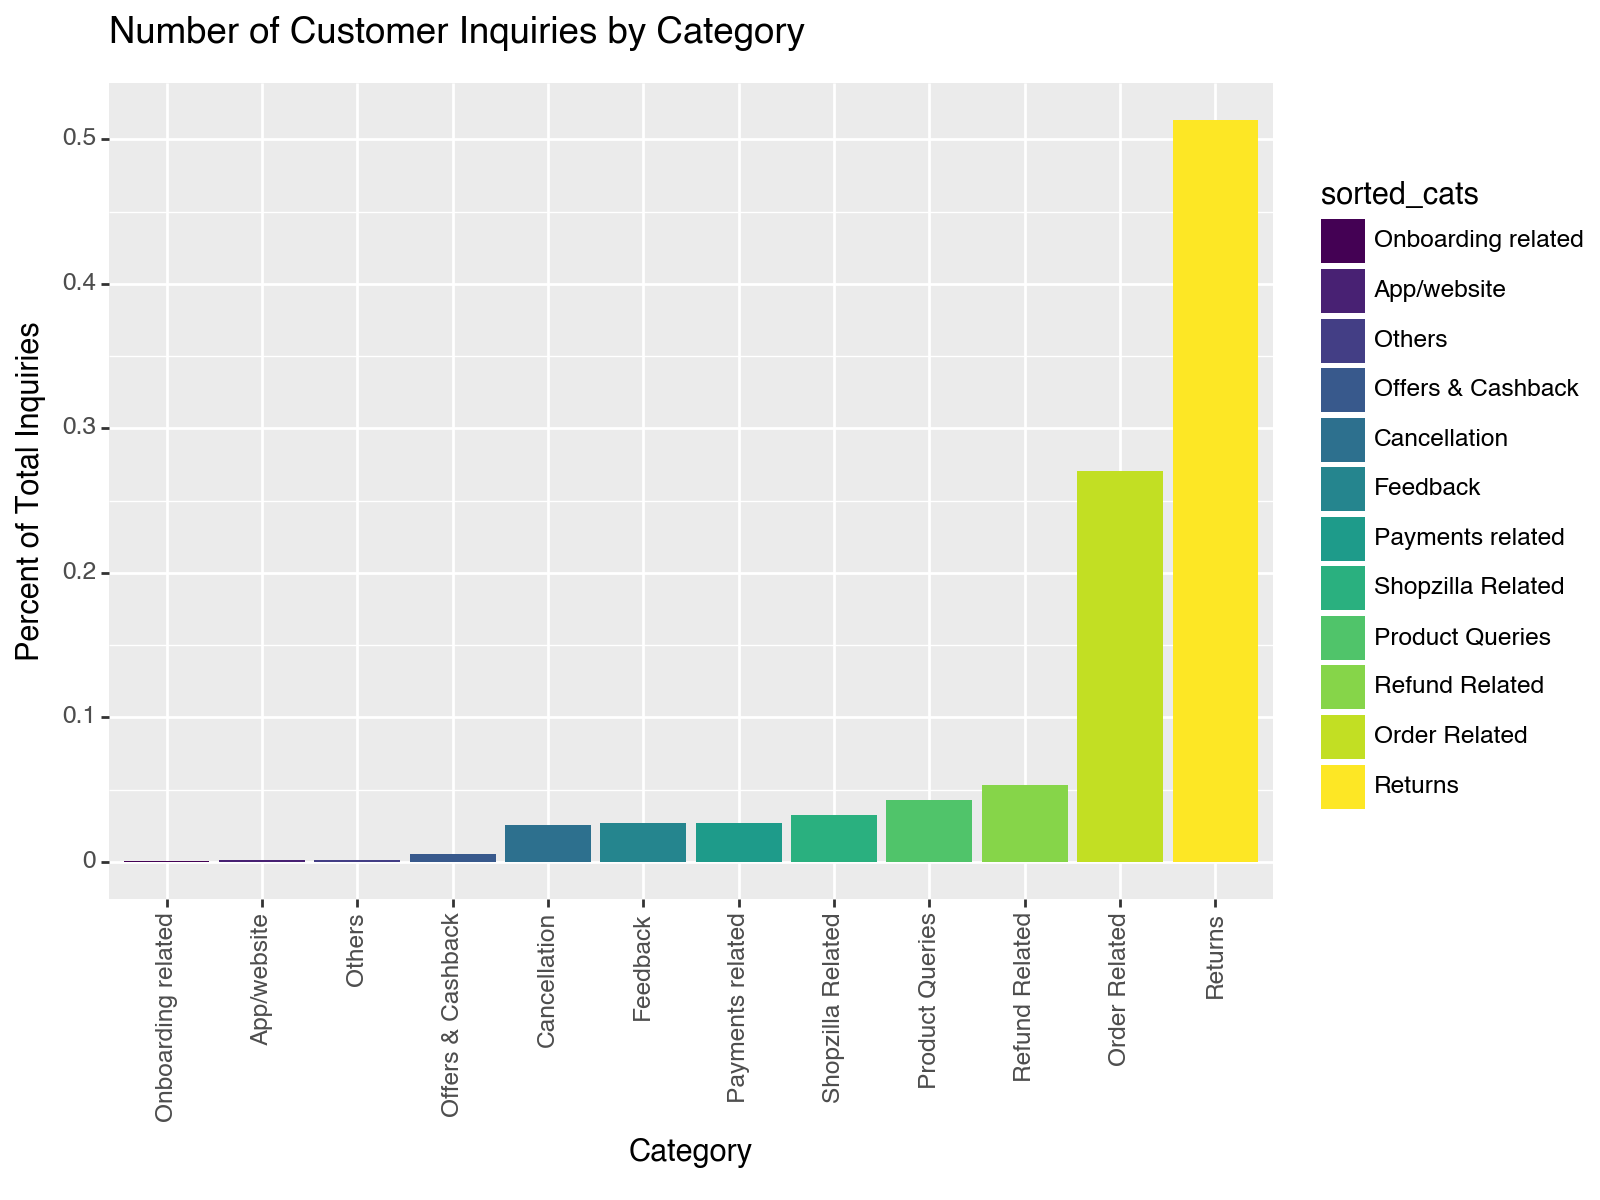

<Figure Size: (800 x 600)>

In [113]:
(
    ggplot(temp_df)
    + aes(x='sorted_cats',y='pct_total', fill='sorted_cats')
    + geom_bar(stat='identity')
    + theme(axis_text_x=element_text(rotation=90), figure_size=(8,6))
    + labs(title="Number of Customer Inquiries by Category", x='Category',y='Percent of Total Inquiries')
)

Basedd on our data, we see that the overwhelming number of customer inquiries are in the category Returns and Order Related. These two categories account for 80% of all customer inquiries

##### *3.7 Number of Issues by Shift*

In [ ]:
pd.DataFrame(cust_satisfaction_df['agent_shift'].value_counts()).reset_index()

,agent_shift,count
0,Morning,41426
1,Evening,33677
2,Afternoon,5840
3,Split,3648
4,Night,1316


We see that the Morning shift is a heavy period for customer inquiries, which makes more sense as to why we would see that the customer satisfaction scores would be lower during that period

#### 4. Machine Learning

For the machine learning portion, we are going to build a decision tree to predict the CSAT Score. Before we do this, we'll need to do some pre-processing to develop a data set that is best equipped to handle this request

Our pre-processing is focused on simplifying our dataframe to only include the features that I feel are actually relevant to the problem of predicting the CSAT score. 

In [116]:
cust_satisfaction_df.head()

,unique_id,channel_name,category,sub_category,customer_remarks,order_id,order_date_time,issue_reported_at,issue_responded,survey_response_date,customer_city,product_category,item_price,connected_handling_time,agent_name,supervisor,manager,tenure_bucket,agent_shift,csat_score
0,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,Outcall,Product Queries,Life Insurance,NaN,c27c9bb4-fa36-4140-9f1f-21009254ffdb,NaN,01/08/2023 11:13,01/08/2023 11:47,01-Aug-23,NaN,NaN,NaN,NaN,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5
1,b07ec1b0-f376-43b6-86df-ec03da3b2e16,Outcall,Product Queries,Product Specific Information,NaN,d406b0c7-ce17-4654-b9de-f08d421254bd,NaN,01/08/2023 12:52,01/08/2023 12:54,01-Aug-23,NaN,NaN,NaN,NaN,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5
2,200814dd-27c7-4149-ba2b-bd3af3092880,Inbound,Order Related,Installation/demo,NaN,c273368d-b961-44cb-beaf-62d6fd6c00d5,NaN,01/08/2023 20:16,01/08/2023 20:38,01-Aug-23,NaN,NaN,NaN,NaN,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5
3,eb0d3e53-c1ca-42d3-8486-e42c8d622135,Inbound,Returns,Reverse Pickup Enquiry,NaN,5aed0059-55a4-4ec6-bb54-97942092020a,NaN,01/08/2023 20:56,01/08/2023 21:16,01-Aug-23,NaN,NaN,NaN,NaN,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5
4,ba903143-1e54-406c-b969-46c52f92e5df,Inbound,Cancellation,Not Needed,NaN,e8bed5a9-6933-4aff-9dc6-ccefd7dcde59,NaN,01/08/2023 10:30,01/08/2023 10:32,01-Aug-23,NaN,NaN,NaN,NaN,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5


Here we list out the different variables and their index so we can easily remove them from our simplified dataframe

In [122]:
pd.DataFrame(cust_satisfaction_df.columns)

,0
0,unique_id
1,channel_name
2,category
3,sub_category
4,customer_remarks
5,order_id
6,order_date_time
7,issue_reported_at
8,issue_responded
9,survey_response_date


In [123]:
keep_cols = [1,2,3,10,11,12,14,15,16,17,18,19,21,22]

In [124]:
csat_df = cust_satisfaction_df.iloc[:,keep_cols]

In [125]:
csat_df.head(5)

,channel_name,category,sub_category,customer_city,product_category,item_price,agent_name,supervisor,manager,tenure_bucket,agent_shift,csat_score,response_date,issue_date
0,Outcall,Product Queries,Life Insurance,NaN,NaN,NaN,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5,2023-08-01,2023-08-01
1,Outcall,Product Queries,Product Specific Information,NaN,NaN,NaN,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5,2023-08-01,2023-08-01
2,Inbound,Order Related,Installation/demo,NaN,NaN,NaN,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5,2023-08-01,2023-08-01
3,Inbound,Returns,Reverse Pickup Enquiry,NaN,NaN,NaN,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5,2023-08-01,2023-08-01
4,Inbound,Cancellation,Not Needed,NaN,NaN,NaN,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5,2023-08-01,2023-08-01


Now I'll make a few additional modififications to the simplified dataframe. 

1. customer_city --> Remove this field since it has a lot of NA values
2. item_price --> Remove this field since it had a lot of NA values
3. product_category --> Remove this field since it has a lot of NA values
4. csat_score --> Change to categorical
5. Create a time to response variable based on issue_date and response_date variable

In [128]:
csat_df_mod = csat_df.loc[:,~csat_df.columns.isin(['customer_city','item_price','product_category'])].copy()

In [129]:
csat_df_mod.head()

,channel_name,category,sub_category,agent_name,supervisor,manager,tenure_bucket,agent_shift,csat_score,response_date,issue_date
0,Outcall,Product Queries,Life Insurance,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5,2023-08-01,2023-08-01
1,Outcall,Product Queries,Product Specific Information,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5,2023-08-01,2023-08-01
2,Inbound,Order Related,Installation/demo,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5,2023-08-01,2023-08-01
3,Inbound,Returns,Reverse Pickup Enquiry,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5,2023-08-01,2023-08-01
4,Inbound,Cancellation,Not Needed,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5,2023-08-01,2023-08-01


As mentioned before, we will now create a variable that represents the time to response

In [131]:
csat_df_mod['response_days'] = csat_df_mod.apply(lambda x: (x['response_date']-x['issue_date']).days,axis=1)

Next we will remove the **issue_date** and **response_date** fields

In [132]:
csat_df_mod = csat_df_mod.loc[:,~csat_df_mod.columns.isin(['issue_date','response_date'])].copy()

Finnaly, we will convert our **csat_score** variable into a categorical variable

In [133]:
csat_df_mod['csat_score'] = pd.Categorical(csat_df_mod['csat_score'])

In [135]:
csat_df_mod.head(8)

,channel_name,category,sub_category,agent_name,supervisor,manager,tenure_bucket,agent_shift,csat_score,response_days
0,Outcall,Product Queries,Life Insurance,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5,0
1,Outcall,Product Queries,Product Specific Information,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5,0
2,Inbound,Order Related,Installation/demo,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5,0
3,Inbound,Returns,Reverse Pickup Enquiry,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5,0
4,Inbound,Cancellation,Not Needed,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5,0
5,Email,Returns,Fraudulent User,Desiree Newton,Emma Park,John Smith,0-30,Morning,5,0
6,Outcall,Product Queries,Product Specific Information,Shannon Hicks,Aiden Patel,Olivia Tan,>90,Morning,5,0
7,Inbound,Returns,Exchange / Replacement,Laura Smith,Evelyn Kimura,Jennifer Nguyen,On Job Training,Evening,5,0


#### 4.1 Decision Tree #1

In [161]:
X1 = mod_df.iloc[:,~mod_df.columns.isin(['csat_score'])]

In [162]:
y = mod_df['csat_score']

In [163]:
X1_dummies = pd.get_dummies(X1,dtype='int')

In [165]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_dummies, y,test_size=0.7)

In [166]:
clf1 = DecisionTreeClassifier()

In [168]:
clf1.fit(X1_train,y1_train)

DecisionTreeClassifier()

In [169]:
clf1.score(X1_test, y1_test)

0.5809096200216181

#### 4.2 Decision Tree #2

In [170]:
X2 = mod_df.iloc[:,~mod_df.columns.isin(['csat_score','response_days'])]

In [171]:
y2 = mod_df['csat_score']

In [172]:
X2_dummies = pd.get_dummies(X2,dtype='int')

In [173]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_dummies, y2,test_size=0.7)

In [155]:
clf2 = DecisionTreeClassifier()

In [174]:
clf2.fit(X2_train,y2_train)

DecisionTreeClassifier()

In [176]:
clf2.score(X2_test, y2_test)

0.576768936559408

#### 4.3 Random Forest

In [178]:
clf3 = RandomForestClassifier(n_estimators = 50)
clf4 = RandomForestClassifier(n_estimators = 50)

In [179]:
clf3.fit(X1_train, y1_train)
clf4.fit(X2_train, y2_train)

RandomForestClassifier(n_estimators=50)

In [160]:
clf3.score(X1_test, y1_test)


0.6340234472437016

In [180]:
clf4.score(X2_test, y2_test)

0.6350378315456888

#### 5. Conclusion